In [ ]:
%%capture
!pip install tensorflow_datasets
!pip install --upgrade tensorflow
!pip install opendatasets
!pip install --upgrade skillsnetwork

Importing Required Libraries

In [ ]:
import numpy as np
import datetime
import os
import random, shutil
import glob
import skillsnetwork

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib.image import imread

from os import makedirs,listdir
from shutil import copyfile
from random import seed
from random import random
import keras
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import opendatasets as od

sns.set_context('notebook')
sns.set_style('white')

2.15.0


Steps to create our classification model:

Import data directly from Kaggle.
Visualize a few random images from the train set.
Load images in using the ImageGeneratorClass from Keras.
Define model configuration options.
Perform some image augmentation for improved model generalizability.
Load, compile and train a pre-trained model like VGG-16.
Perform inference on the test set.

Importing Data

create a `o-vs-r-split` directory in your environment

In [ ]:
import skillsnetwork
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/datasets/o-vs-r-split.tar.gz",
                           overwrite=True)

  0%|          | 0/8097 [00:00<?, ?it/s]

Saved to '.'


# **Define configuration options**

It's time to define some model configuration options.

*   **img_rows** and **img_cols** are used to specify width and height of the images expected by MobileNet.
*   **batch size** is set to 32.
*   The **number of epochs** (i.e. iterations) is set to 5, but as we are using Early Stopping, the number of iterations might be lower if early stopping conditions are met before 5 iterations.
*   The **number of classes** is 2.
*   We will use 20% of the data for **validation** purposes.
*   We want to be able to see the model output, so we set **verbosity** to 1, or True.
*   **path** is a path to the directory with the training data and **path_test** should contain the test data.
*   The **input_shape** is common for an image: (w, h, d).
*   We have two **labels** in our dataset: organic (O), recyclable (R).
*   The **checkpoint_path** is where ModelCheckpoint will save our model.


In [ ]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3) #RGB
labels = ['O', 'R']
seed = 10
checkpoint_path='ORnet.h5'

### Loading Images using ImageGeneratorClass


Transfer learning works best when models are trained on smaller datasets. We are using 10,000 images from original dataset of 25,000 images. We are setting aside 10% of the set for testing purposes.


The folder structure looks as follows:

```python
o-vs-r-split/
└── train
    ├── O
    └── R
└── test
    ├── O
    └── R
```

#### Image Augmentation

Now we will create ImageDataGenerators used for training, validation and testing.

Image data generators create batches of tensor image data with real-time data augmentation. They loop over the data in batches and are useful in feeding data to the training process. We specify a 20% validation split.

We will perform a few image augmentation steps. We set **rescale** to 1./255. This means that each image pixel will be divided by 255 in order to normalize the image. We set the **width_shift_range** and **height_shift_range** to 0.1 each, and the **horizontal_flip** to True.

*   **width_shift_range** shifts the image horizontally (left or right).
*   **height_shift_range** shifts the image vertically (up or down).
*   **horizontal_flip** randomly flip inputs horizontally.


In [ ]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

Since it is undesirable to load all of our image data into memory all at once, we make use of **flow_from_directory** method. It takes the ImageDataGenerator training/validation sets and flows image batches from a specified folder.

*   **directory** is set to the **path**, specifying the path to our training dataset.
*   We specify classes using **labels** we had defined in the configuration step.
*   We apply a **seed** so our random initializer is generated in the same way each time we perform this step. This allows for direct comparison between experiments.


In [ ]:
# use the labels defined before to
# find number of images belonging to each category
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'training'
)

Found 5810 images belonging to 2 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'validation'
)

Found 1452 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    classes = labels,
    class_mode='binary',
    seed = seed,
    batch_size = batch_size,
    shuffle = True,
    target_size=(img_rows, img_rows)
)

Found 828 images belonging to 2 classes.


5920 images belonging to 2 classes were found in the train directory, and 1479 images belonging to the same two classes were found in the validation directory, and 823 images were found in the test set.

Let's look at a few augmented images:

Labels: ['O', 'O', 'O', 'O', 'O']


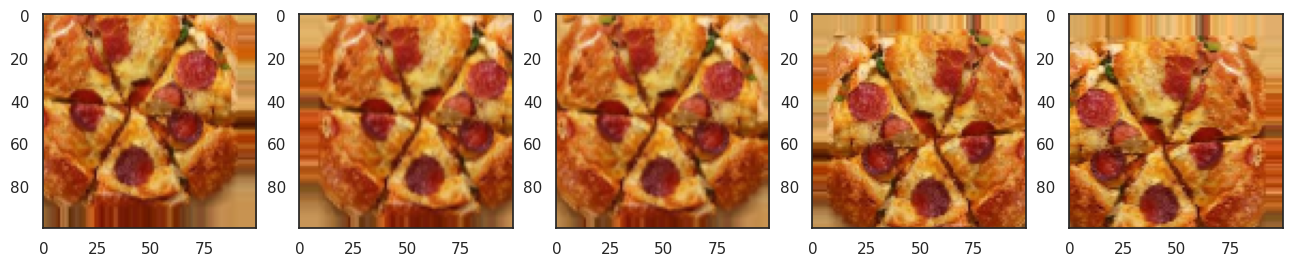

In [ ]:
IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3].split('.')[0].strip() for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]


### Pre-trained Models

Pre-trained models are saved networks that have previously been trained on some large (somewhat related) datasets. They are typically used for large-scale image-classification task. They can be used as they are or could be customized to a given task using transfer learning. These pre-trained models form the basis of transfer learning.

We can leverage a pre-trained model's weighted layers to extract generic features. In this step we would not update the model's layer's weights during training. This helps us utilize the knowledge from a source-domain task.

Fine-tuning, which is a more involved process, involves more than just replacing the final layer. We also try to retrain some of the previous layers.

In computer vision, some popular pre-trained models include: VGG-16, VGG-19, InceptionV3, XCeption and ResNet-50.


#### VGG-16

Let us load the VGG16 model.

```python
tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_shape=None,
)
```

The default input image size for this model is 224x224.

Further information on arguments can be found in the Keras [documentation](https://keras.io/api/applications/vgg/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01).

> Note: each Keras Application expects a specific kind of input preprocessing. For VGG16, call `tf.keras.applications.vgg16.preprocess_input` on your inputs before passing them to the `model.vgg16.preprocess_input` will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

> *   **include_top**: whether to include the fully-connected layer at the top of the network.
> *   **weights**: one of None (random initialization), 'imagenet' (pre-trained on ImageNet), or the path to the weights file to be loaded.
> *   **input_shape**: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3).


First, we load the model:

In [ ]:
from keras.applications import vgg16
input_shape = (150, 150, 3)

vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

58889256/58889256 [==============================] - 0s 0us/step


We flatten the output of a vgg model and assignee it to the model `output`, we then use a Model object `basemodel` to group the layers into an object for training and inference .
With the following inputs and outputs

inputs: `vgg.input`

outputs: `tf.keras.layers.Flatten()(output)`


In [ ]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

Next, we freeze the basemodel, i.e the lower layers

In [ ]:
basemodel.trainable = False
for layer in basemodel.layers: layer.trainable = False

Create a new model on top. We add a Dropout layer for regularization, only these layers will change as for the lower layers we set training=False when calling the base model.

In [ ]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

Let us print the model summary.

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8192)              14714688  
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 19172673 (73.14 MB)
Trainable params: 4457

Calling `compile()` freezes the behavior of that model, implying that the trainable attribute values at the time of compilation are preserved.

We use RMSProp as our optimizer with a learning rate of 2e-5, Binary Cross Entropy Loss as our loss function and Accuracy as our primary metric for model evaluation as we have 2 labels in our dataset.


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])


We use early stopping to avoid over-training the model. An over-trained model overfits the training dataset and has poor performance on unseen test sets. We will also use a exponential step-decay based learning rate scheduler.

In [ ]:
from keras.callbacks import LearningRateScheduler
checkpoint_path='O_R_tlearn_image_augm_cnn_vgg16.h5'

# define step decay function
class LossHistory_(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'loss',
                    patience = 5,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_, keras_callbacks]

### Fit and train the model


In [ ]:
extract_feat_model = model.fit(train_generator,
                              steps_per_epoch=10,
                              epochs=5,
                              validation_data=val_generator,
                              validation_steps=10,
                              verbose=1,
                              callbacks = callbacks_list_)

Epoch 1/5
10/10 [==============================] - 154s 16s/step - loss: 99882.1641 - accuracy: 0.4812 - val_loss: 325.8170 - val_accuracy: 0.6438 - lr: 0.1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/5
10/10 [==============================] - 153s 16s/step - loss: 403.8597 - accuracy: 0.6750 - val_loss: 61.6547 - val_accuracy: 0.8281 - lr: 0.0905
Epoch 3/5
10/10 [==============================] - 152s 16s/step - loss: 90.9574 - accuracy: 0.6875 - val_loss: 7.8275 - val_accuracy: 0.6500 - lr: 0.0819
Epoch 4/5
10/10 [==============================] - 152s 16s/step - loss: 6.7619 - accuracy: 0.7281 - val_loss: 4.8821 - val_accuracy: 0.6781 - lr: 0.0741
Epoch 5/5
10/10 [==============================] - 153s 16s/step - loss: 39.9785 - accuracy: 0.6281 - val_loss: 3.1553 - val_accuracy: 0.6438 - lr: 0.0670


### Fine-Tuning

Fine-tuning is an optional step in transfer learning, it usually ends up improving the performance of the model. It is easy to overfit the model in this step as we are re-training the entire model. So we use regularization (dropout layers), a lower learning rate, a small number of epochs (training iterations), and early stopping to know when the model has stopped improving and to prevent overfitting.

In order to fine-tune our model, we will use use the VGG-16 model object stored in the `basemodel` variable. We will unfreeze convolution blocks 4 and 5 and keep the first 3 blocks frozen. This ensures that the convolution and pooling layers for blocks 4 and 5 are trainable, i.e. weights get updated through backpropagation in each training iteration or epoch.


We can find the name of each layer:

In [ ]:
[layer.name for layer in basemodel.layers]

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten']

We then set `'block5_conv1'`and ` 'block4_conv1'  ` to trainable


In [ ]:
basemodel.trainable = True

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Similar to what we did before, we create a new model on top, and add a Dropout layer for regularization, and set training=False when calling the base model.

In [ ]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_image_augm_fine_tune_vgg16.h5'


# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'loss',
                    patience = 5,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_, keras_callbacks]

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator,
                    steps_per_epoch=10,
                    epochs=5,
                    callbacks = callbacks_list_,
                    validation_data=val_generator,
                    validation_steps=10,
                    verbose=1)

Epoch 1/5
10/10 [==============================] - 215s 22s/step - loss: 15252425300508672000.0000 - accuracy: 0.5094 - val_loss: 413154.1250 - val_accuracy: 0.5688 - lr: 0.1000
Epoch 2/5
10/10 [==============================] - 211s 22s/step - loss: 263324.9375 - accuracy: 0.5219 - val_loss: 209687.2188 - val_accuracy: 0.4469 - lr: 0.0905
Epoch 3/5
10/10 [==============================] - 212s 22s/step - loss: 95400.1875 - accuracy: 0.5156 - val_loss: 12390.6855 - val_accuracy: 0.5875 - lr: 0.0819
Epoch 4/5
10/10 [==============================] - 219s 23s/step - loss: 15875.1377 - accuracy: 0.4812 - val_loss: 3210.0237 - val_accuracy: 0.4625 - lr: 0.0741
Epoch 5/5
10/10 [==============================] - 215s 22s/step - loss: 6502.4492 - accuracy: 0.5312 - val_loss: 3872.8496 - val_accuracy: 0.4625 - lr: 0.0670


The fine tuned model has a validation accuracy higher than the previous transfer learning model.

### Evaluate both models on test data


Load saved models:

In [ ]:
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_image_augm_cnn_vgg16.h5')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_image_augm_fine_tune_vgg16.h5')

Load test images:

In [ ]:
from sklearn.utils import shuffle


IMG_DIM = (150, 150)

# Read in all O and R test images file paths. Shuffle and select 50 random test images.
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O + test_files_R
test_files = shuffle(test_files)[0:50]

# Extract label from file path
test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[3].split('.')[0].strip() for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

In [ ]:
class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

In [ ]:
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

In [ ]:
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

In [ ]:
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

Extract Features Model
              precision    recall  f1-score   support

           O       0.68      0.61      0.64        31
           R       0.45      0.53      0.49        19

    accuracy                           0.58        50
   macro avg       0.57      0.57      0.57        50
weighted avg       0.59      0.58      0.58        50

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.00      0.00      0.00        31
           R       0.38      1.00      0.55        19

    accuracy                           0.38        50
   macro avg       0.19      0.50      0.28        50
weighted avg       0.14      0.38      0.21        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Custom image: Is your waste organic or a recyclable?

With this, now you are all set to see if a waste product is a organic or a recyclable! Below, simply specify the file path (`FILE_PATH_TO_YOUR_IMAGE`) to your custom image, and it will return the class prediction. 🥳


['O']

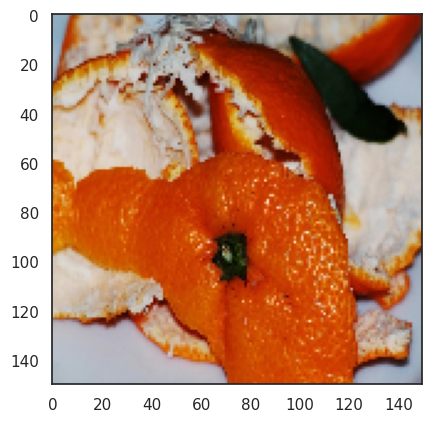

In [ ]:
# Load the original image and resize it to IMG_DIM
orig_im = tf.keras.preprocessing.image.load_img("/content/orange-peel-517567_640.jpg", target_size=IMG_DIM)
plt.imshow(orig_im)

# Convert to array and rescale the image values
custom_im = tf.keras.preprocessing.image.img_to_array(orig_im)
custom_im_scaled = custom_im.astype('float32')
custom_im_scaled /= 255

# Predict the waste category
num2class_lt(extract_feat_model.predict(custom_im_scaled.reshape((1,IMG_DIM[0], IMG_DIM[1],3)), verbose=0))

['R']

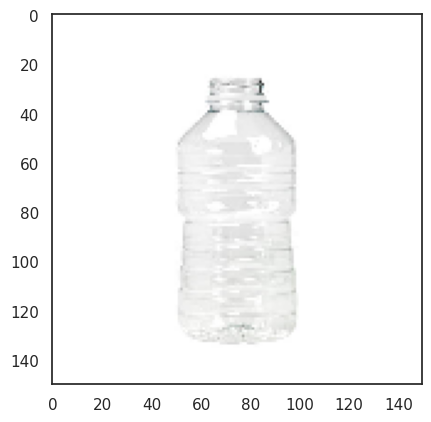

In [ ]:
# Load the original image and resize it to IMG_DIM
orig_im = tf.keras.preprocessing.image.load_img("/content/bottle.jpg", target_size=IMG_DIM)
plt.imshow(orig_im)

# Convert to array and rescale the image values
custom_im = tf.keras.preprocessing.image.img_to_array(orig_im)
custom_im_scaled = custom_im.astype('float32')
custom_im_scaled /= 255

# Predict the waste category
num2class_lt(extract_feat_model.predict(custom_im_scaled.reshape((1,IMG_DIM[0], IMG_DIM[1],3)), verbose=0))